In [122]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
import time

# Load .npy files
X = np.load('cifar10_features.npy')
y = np.load('cifar10_labels.npy')

# Split into training and test sets (70% train / 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Make sure npy files are of the correct size
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (50000, 16)
y shape: (50000,)


Build OVA classifier

In [123]:
import numpy as np  
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix  
import time  

class MyOVA:
    def __init__(self):
        self.models = []        # List to store one logistic regression model per class
        self.classes_ = None    # Stores the unique class labels
        self.train_time_ = None # Stores the training time in seconds

    def fit(self, X, y):
        """
        Train one binary classifier per class.
        """
        self.classes_ = np.unique(y)  # Get the list of all unique class labels
        self.models = []

        start = time.time()  # Start timer

        for cls in self.classes_:
            # Create binary labels: 1 if the sample is from this class, else 0
            binary_y = (y == cls).astype(int)

            # Train a logistic regression model on this binary classification task
            model = LogisticRegression(max_iter=1000)
            model.fit(X, binary_y)

            # Save the trained model
            self.models.append(model)

        # Save how long the training took
        self.train_time_ = time.time() - start

    def predict(self, X):
        """
        Predict the class for each input by selecting the model that gives the highest probability.
        """
        # Each model gives the probability for its class (class vs. rest)
        probas = np.array([model.predict_proba(X)[:, 1] for model in self.models])

        # Choose the class with the highest predicted probability
        return np.argmax(probas, axis=0)

    def predict_proba(self, X):
        """
        Return probability estimates for each class.
        Normalized so that each row sums to 1.
        """
        # Get raw scores (probability of class 1) from each model
        raw_scores = np.array([model.predict_proba(X)[:, 1] for model in self.models]).T

        # Normalize the scores so that they form a valid probability distribution
        row_sums = np.sum(raw_scores, axis=1, keepdims=True)
        normalized_scores = raw_scores / row_sums

        return normalized_scores

    def score(self, X, y):
        """
        Return the accuracy.
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [124]:
# Start measuring the time before training begins
start_time = time.time()

model_softmax = LogisticRegression(solver='lbfgs', max_iter=1000)

# Train the model on the training data
model_softmax.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_softmax = model_softmax.predict(X_test)

# Calculate the accuracy of the model
accuracy_softmax = accuracy_score(y_test, y_pred_softmax)

# Calculate the log loss 
loss_softmax = log_loss(y_test, model_softmax.predict_proba(X_test))

# Calculate the F1 score 
f1_softmax = f1_score(y_test, y_pred_softmax, average='macro')

# Measure how much time the training and prediction took
time_softmax = time.time() - start_time


In [125]:
# Create instance of MyOVA
model_ova = MyOVA()

# Start measuring time
start_time = time.time()

# Train the model on the data
model_ova.fit(X_train, y_train)

# Predict using the trained model
y_pred_ova = model_ova.predict(X_test)

# Calculate evaluation metrics
accuracy_ova = model_ova.score(X_test, y_test)
loss_ova = log_loss(y_test, model_ova.predict_proba(X_test))
f1_ova = f1_score(y_test, y_pred_ova, average='macro')
conf_matrix_ova = confusion_matrix(y_test, y_pred_ova)
time_ova = time.time() - start_time

In [126]:
print("=== One-vs-All ===")
print("Accuracy:", accuracy_ova)
print("Loss:", loss_ova)
print("F1-mean:", f1_ova)
print("Time:", time_ova)
print("Confusion Matrix:\n", conf_matrix_ova)

print("\n=== Softmax ===")
print("Accuracy:", accuracy_softmax)
print("Loss:", loss_softmax)
print("F1-mean:", f1_softmax)
print("Time:", time_softmax)


=== One-vs-All ===
Accuracy: 0.961
Loss: 0.13459723836914392
F1-mean: 0.961210892245097
Time: 1.0254437923431396
Confusion Matrix:
 [[1402    2   13    5    5    3    2   10   17    5]
 [   2 1464    4    1    0    1    0    1    5    7]
 [  11    1 1370   15   16   15    5    3    1    3]
 [  14    5   15 1450   12   51    5   10    3    4]
 [   6    0   13   15 1466    5    4    9    0    1]
 [   2    3   13   45   12 1437    8   11    2    1]
 [   5    5    9   17    4    6 1415    0    1    1]
 [   3    0    4   17    9    7    0 1456    0    1]
 [  13    2    1    5    1    0    2    0 1480    6]
 [  12    7    5    6    0    4    2    3    5 1475]]

=== Softmax ===
Accuracy: 0.963
Loss: 0.10766362719776983
F1-mean: 0.9632337955753935
Time: 2.0988001823425293


In [127]:
# This function tests a given model on input data and returns its accuracy
def testmymodel(model, X_data, y_data):
    # Use the model to predict labels for the input data
    y_pred = model.predict(X_data)

    # Calculate and return the accuracy of the predictions
    return accuracy_score(y_data, y_pred)


In [128]:
print("OVA Test Accuracy:", testmymodel(model_ova, X_test, y_test))
print("Softmax Test Accuracy:", testmymodel(model_softmax, X_test, y_test))


OVA Test Accuracy: 0.961
Softmax Test Accuracy: 0.963


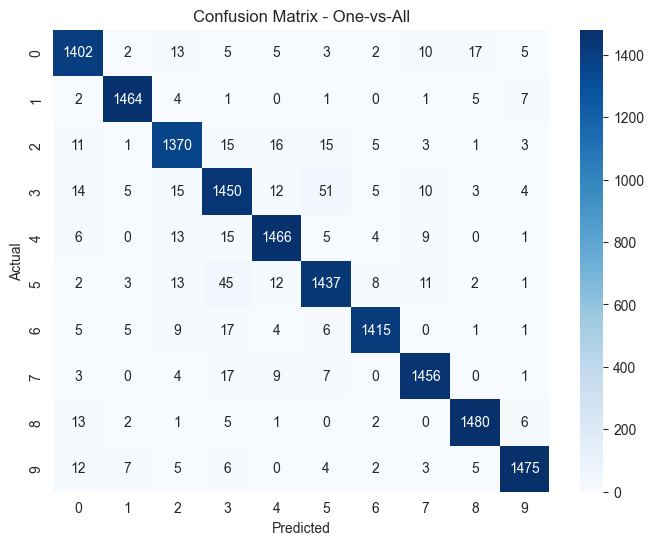

In [129]:
import seaborn as sns  
import matplotlib.pyplot as plt  

# Set the figure size for the plot
plt.figure(figsize=(8,6))

# Create a heatmap to visualize the confusion matrix for the One-vs-All model
sns.heatmap(conf_matrix_ova, annot=True, fmt='d', cmap='Blues')

# Add title and axis labels
plt.title("Confusion Matrix - One-vs-All")
plt.xlabel("Predicted")  # X-axis: predicted class labels
plt.ylabel("Actual")     # Y-axis: true class labels

# Show the plot
plt.show()


In [130]:
# Keep only samples from classes 3 and 5
mask = (y_train == 3) | (y_train == 5)

# Filter features and labels for the binary task
X_binary = X_train[mask]
y_binary = y_train[mask]

# Train a logistic regression model to distinguish between class 3 and 5
model_binary = LogisticRegression()
model_binary.fit(X_binary, y_binary)

print("Binary Accuracy:", model_binary.score(X_binary, y_binary))

Binary Accuracy: 0.9594026388284761
